In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import copy
import random
import numpy as np
import axelrod as axl
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
from itertools import permutations
from collections import namedtuple, deque

np.set_printoptions(precision=3)

# the following imports are from network / axl_utils folder
import network
from network.dqn import DQN
from network.replay import ReplayMemory
from axl_utils.nnplayer import NNplayer, State
from axl_utils.game import *

In [3]:
C = axl.Action.C
D = axl.Action.D

# config game rules
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

In [4]:
# play sanity check
play(axl.Alternator(), axl.Random())
game = play(axl.Prober4(), axl.TitForTat())

[(0, 5), (5, 0), (3, 3), (5, 0), (0, 5), (1, 1), (0, 5), (5, 0), (0, 5), (1, 1), (3, 3), (5, 0), (3, 3), (5, 0), (3, 3), (1, 1), (3, 3), (5, 0), (0, 5), (1, 1)]
Player 1 score = 49
Player 2 score = 44
[(3, 3), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (1, 1), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (0, 5), (5, 0)]
Player 1 score = 50
Player 2 score = 45


In [5]:
# State sanity check
s = State(GAME_LEN)
print(s.values())

s.push(C, D)
print(s)

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]]
[deque([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1], maxlen=21),
 deque([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0], maxlen=21)]


### Section 1: DQN

In [6]:
dqn = DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            ReplayMemory(2000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 1e-4, 'batch': 16, "momentum": 0.9, "mode": "train", "eps": 1e-16, "beta":(0.9, 0.999), 
         "epoch": 0, 'optimizer': 'adam', 't': 1, 'clip': 1.0, 'decay': 0.0, "loss_fn":"mse"}

In [7]:
with p1:
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
    
# initial Q_values:

[[-2.568 -0.657]]
[[-2.739 -1.097]]
[[-1.584 -0.952]]
[[-1.435 -0.688]]
[[-1.532 -0.976]]
[[-0.819 -1.406]]
[[-0.899 -0.69 ]]
[[-1.421 -0.296]]
[[-1.129 -0.662]]
[[-1.103 -0.547]]
[[-1.34 -0.66]]
[[-1.429 -0.601]]
[[-1.015 -1.69 ]]
[[-1.425 -1.027]]
[[-1.771 -1.053]]
[[-2.247  0.116]]
[[-0.396 -0.817]]
[[-0.865 -0.501]]
[[-1.139 -0.488]]
[[-1.33  -0.799]]
[[-1.412 -0.382]]


In [8]:
# initial experience
# high greedy -> more random exploration

p1.set_greedy(0.8)
for i in range(60):
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
p1.set_greedy(0.2)

In [9]:
# theoritical Q values
# assuming the player cooperate til the last turn, then defect
for i in range(20):
    print(f'{3.0+3.0/(1/9) * (1.0 - 1.0/(1.0+1/9)**(19-i)) + 2:.2f}')
true_Q = np.array([3.0+3.0/(1/9) * (1.0 - 1.0/(1.0+1/9)**(19-i)) + 2 for i in range(21)])
true_Q[20] = 0.0

28.35
27.95
27.50
27.00
26.44
25.82
25.14
24.37
23.53
22.59
21.54
20.38
19.09
17.65
16.06
14.29
12.32
10.13
7.70
5.00


In [10]:
# training loop

score_ls = []
errors = []
for _ in range(20):
    start = time()
    p1.train(30, param)
    
    # collect new experience with trained network
    [Match((p1, axl.TitForTat())).play() for _ in range(10)]
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # calculating Q-value error for later use
    # a bit tedious here but I'm too lazy to fix
    values = []
    state = State(21)
    for i in range(21):
        value = p1.network(state.values())[0]
        values.append(value[0])
        state.push(C, C)
    error = true_Q - np.array(values)
    errors.append(error)


# left: running loss for cooperation
# right: running loss for defection

loss: [0.093 0.107],            time: +8.22 sec
loss: [0.08  0.086],            time: +11.11 sec
loss: [0.073 0.055],            time: +12.85 sec
loss: [0.061 0.062],            time: +15.80 sec
loss: [0.052 0.047],            time: +15.60 sec
loss: [0.042 0.056],            time: +14.83 sec
loss: [0.036 0.037],            time: +15.75 sec
loss: [0.066 0.065],            time: +12.90 sec
loss: [0.031 0.038],            time: +13.65 sec
loss: [0.045 0.048],            time: +12.76 sec
loss: [0.023 0.036],            time: +15.15 sec
loss: [0.041 0.056],            time: +14.33 sec
loss: [0.024 0.039],            time: +13.34 sec
loss: [0.019 0.041],            time: +14.40 sec
loss: [0.026 0.03 ],            time: +14.56 sec
loss: [0.028 0.049],            time: +15.35 sec
loss: [0.036 0.045],            time: +15.16 sec
loss: [0.022 0.025],            time: +14.56 sec
loss: [0.028 0.029],            time: +14.49 sec
loss: [0.024 0.036],            time: +14.57 sec


In [11]:
with p1:
    play(p1, axl.TitForTat())
# predicted Q-values:

[[26.398 25.742]]
[[26.005 25.394]]
[[25.75  25.094]]
[[25.504 24.811]]
[[24.945 24.274]]
[[24.282 23.555]]
[[23.651 22.93 ]]
[[22.961 22.258]]
[[22.207 21.391]]
[[21.293 20.546]]
[[20.372 19.644]]
[[19.244 18.541]]
[[18.148 17.445]]
[[16.782 16.104]]
[[15.32  14.538]]
[[13.648 12.871]]
[[11.896 11.119]]
[[9.824 8.993]]
[[7.562 5.969]]
[[3.036 5.014]]
[[ 0.002 -0.074]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


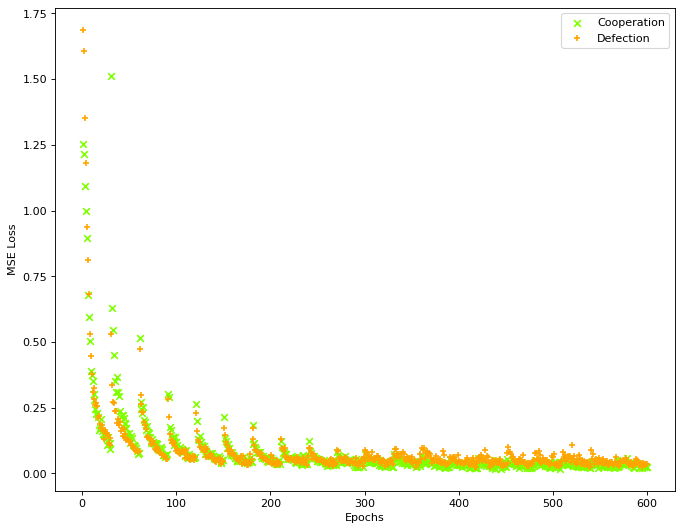

In [12]:
# training loss
p1.plot()

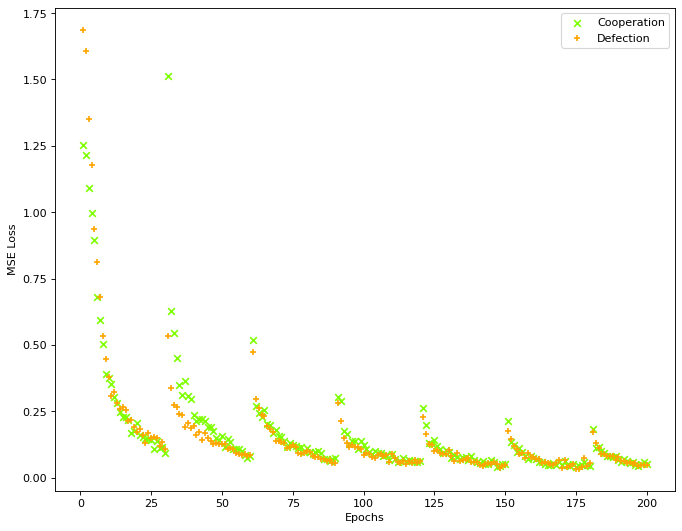

In [13]:
# training loss in first 200 epochs
p1.plot(min_ran=0, max_ran=200)

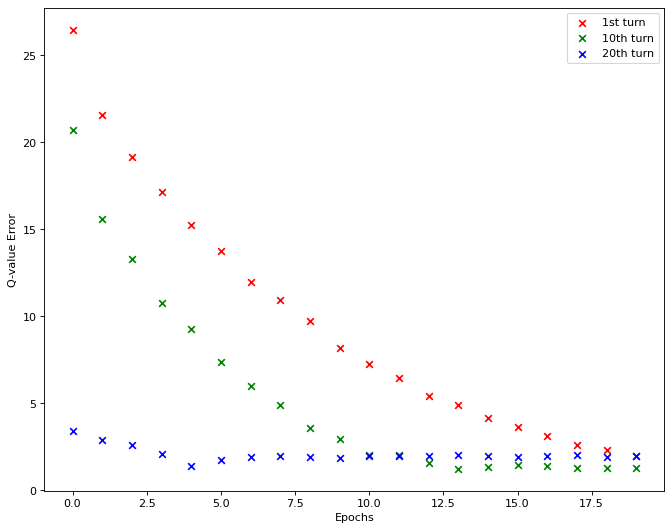

In [14]:
# visualizing the recursion nature of Bellman's equation,
# where the later states has to be learnt prior to learning preceding states

# plotting the error between our prediction against the theoritical Q-value
errors = np.array(errors)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(len(errors)), errors[:,0], c='r', marker='x', label='1st turn')
plt.scatter(range(len(errors)), errors[:,9], c='g', marker='x', label='10th turn')
plt.scatter(range(len(errors)), errors[:,19], c='b', marker='x', label='20th turn')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Q-value Error')
plt.show()

### Section 2: DQN without fixed target

In [15]:
dqn2 = DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            ReplayMemory(2000), gamma=0.9, greedy=0.2)
p2 = NNplayer(dqn2, State(GAME_LEN))
del dqn2
gc.collect()

param = {"lr": 1e-4, 'batch': 16, "momentum": 0.9, "mode": "train", "eps": 1e-16, "beta":(0.9, 0.999), 
         "epoch": 0, 'optimizer': 'adam', 't': 1, 'clip': 1.0, 'decay': 0.0, "loss_fn":"mse"}

p2.set_greedy(0.8)
for i in range(60):
    players = (p2, axl.TitForTat())
    game = Match(players)
    game.play()
p2.set_greedy(0.2)

for _ in range(100):
    start = time()
    
    p2.train(1, param)  # my train function updates target net at the end via deepcopy, we can overwrite this by
    p2.network.target_net = p2.network.policy_net  # SHALLOW COPY policy net to target net
    
    [Match((p2, axl.TitForTat())).play() for _ in range(10)]
    print(f'loss: {p2.network.loss},            time: +{time()-start:.2f} sec')

loss: [1.288 1.895],            time: +0.61 sec
loss: [2.569 2.198],            time: +0.66 sec
loss: [2.589 2.152],            time: +0.69 sec
loss: [2.785 2.866],            time: +0.74 sec
loss: [2.735 2.935],            time: +0.86 sec
loss: [3.068 3.226],            time: +0.86 sec
loss: [3.265 3.311],            time: +0.89 sec
loss: [3.262 4.062],            time: +0.80 sec
loss: [3.458 3.978],            time: +0.74 sec
loss: [3.811 4.189],            time: +0.86 sec
loss: [3.74 5.05],            time: +0.83 sec
loss: [4.108 5.615],            time: +0.84 sec
loss: [4.811 6.442],            time: +0.80 sec
loss: [5.312 7.449],            time: +0.79 sec
loss: [5.216 9.122],            time: +0.93 sec
loss: [ 6.873 11.148],            time: +0.95 sec
loss: [ 7.317 11.966],            time: +0.70 sec
loss: [ 8.407 11.578],            time: +0.70 sec
loss: [ 9.167 14.819],            time: +0.69 sec
loss: [10.047 19.018],            time: +0.72 sec
loss: [11.806 16.186],          

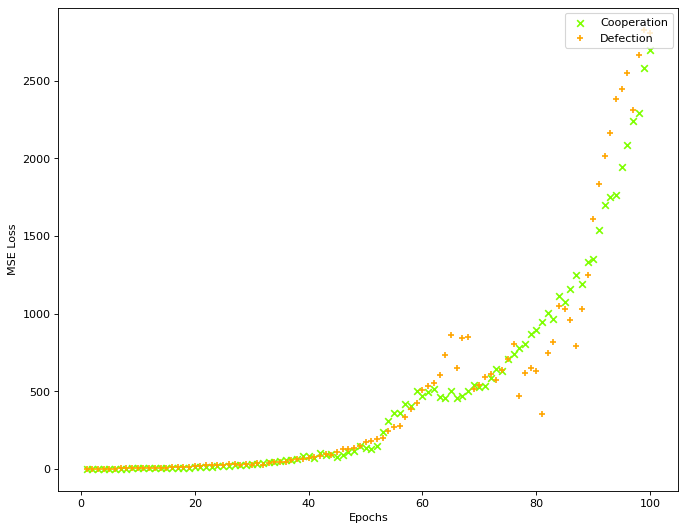

In [16]:
p2.plot()

In [17]:
del p2

### Section 3: testing the off-policyness

In [18]:
from axl_utils.extract import extract

In [19]:
# collecting experience from axl.Random
memory = ReplayMemory(10000)
for _ in range(500):
    game = play(axl.Random(), axl.TitForTat(), show=False)
    extract(game, memory)

In [20]:
dqn3 = DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            memory, gamma=0.9, greedy=0.2)
p3 = NNplayer(dqn3, State(GAME_LEN))
del dqn3
gc.collect()

param = {"lr": 1e-4, 'batch': 16, "momentum": 0.9, "mode": "train", "eps": 1e-16, "beta":(0.9, 0.999), 
         "epoch": 0, 'optimizer': 'adam', 't': 1, 'clip': 1.0, 'decay': 0.0, "loss_fn":"mse"}

In [21]:
for _ in range(20):
    start = time()
    p3.train(5, param)
    print(f'loss: {p3.network.loss},            time: +{time()-start:.2f} sec')

loss: [0.182 0.217],            time: +14.32 sec
loss: [0.216 0.167],            time: +12.43 sec
loss: [0.153 0.169],            time: +13.06 sec
loss: [0.104 0.116],            time: +13.88 sec
loss: [0.097 0.123],            time: +15.29 sec
loss: [0.104 0.122],            time: +15.15 sec
loss: [0.103 0.091],            time: +13.79 sec
loss: [0.087 0.109],            time: +14.80 sec
loss: [0.086 0.079],            time: +13.94 sec
loss: [0.057 0.061],            time: +14.31 sec
loss: [0.071 0.076],            time: +14.87 sec
loss: [0.073 0.068],            time: +13.21 sec
loss: [0.083 0.056],            time: +11.84 sec
loss: [0.06  0.072],            time: +11.44 sec
loss: [0.042 0.056],            time: +14.76 sec
loss: [0.056 0.06 ],            time: +12.93 sec
loss: [0.046 0.053],            time: +15.40 sec
loss: [0.051 0.067],            time: +14.86 sec
loss: [0.056 0.051],            time: +10.59 sec
loss: [0.046 0.05 ],            time: +12.29 sec


In [22]:
with p3:
    play(p3, axl.TitForTat())

[[26.292 25.711]]
[[25.933 25.376]]
[[25.478 24.895]]
[[25.106 24.488]]
[[24.665 24.023]]
[[23.994 23.429]]
[[23.307 22.738]]
[[22.685 22.063]]
[[21.906 21.238]]
[[20.904 20.283]]
[[20.052 19.291]]
[[18.892 18.208]]
[[17.619 17.054]]
[[16.282 15.718]]
[[14.824 14.029]]
[[13.224 12.777]]
[[11.374 10.973]]
[[9.463 9.045]]
[[7.173 6.102]]
[[3.098 4.966]]
[[0.054 0.16 ]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


In [23]:
del p3

### Section 4: did it learn Tit-For-Tat?

In [61]:
# might be an obvious question but let's see what happens if our DQN meets provocative defection

p1.network.greedy = 0.0
play(p1, axl.HardProber());  # hard prober defects forever if its opponent does not retaliate

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (1, 1)]
Player 1 score = 7
Player 2 score = 92


In [62]:
play(axl.Cooperator(), axl.HardProber());  # our DQN is basically a naive cooperator

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5)]
Player 1 score = 6
Player 2 score = 96


In [63]:
play(axl.TitForTat(), axl.HardProber());

[(0, 5), (1, 1), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Player 1 score = 57
Player 2 score = 57


In [50]:
# => continue the exploration on Stage 2